In [2]:
from tkinter import filedialog
from tkinter import Tk
import pandas as pd
import os
import pickle

root = Tk()
root.withdraw()

# Read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))
Sim_File_path = filedialog.askopenfilename(title="Select Sim-result file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))

# Define data
df_setting = pd.read_excel(Setting_File_path)
feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

df = pd.read_csv(csv_file_path)
dfsim = pd.read_csv(Sim_File_path)

# Mode check @ Real-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


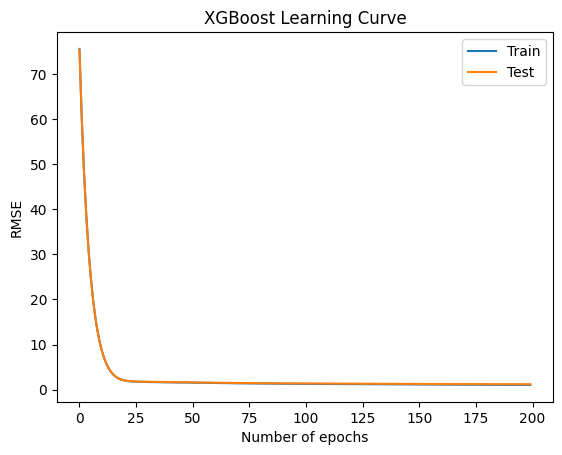

Average RMSE: 1.194816337459133, Average R2: 0.9958336002498547


In [3]:
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import math

def prepare_kfold_data(df, target_var, feature_vars):
    X = df[feature_vars]
    y = df[target_var]
    return X, y

def objective(trial, X, y):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    max_depth = trial.suggest_int('max_depth', 3, 5)
    
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, objective='reg:squarederror')
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        mse = mean_squared_error(y_test, model.predict(X_test))
        mse_scores.append(mse)
        
    return np.mean(mse_scores)


def optimize_hyperparameters(X, y):
    current_directory = os.getcwd()
    Hyperparameter_File_path = os.path.join(current_directory, f'best_params_kfold.pkl')

    try:
        with open(Hyperparameter_File_path, 'rb') as f:
            best_params = pickle.load(f)
    except FileNotFoundError:
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X, y), n_trials=100)
        best_params = study.best_params
        with open(Hyperparameter_File_path, 'wb') as f:
            pickle.dump(best_params, f)
    
    return best_params


def kfold_evaluate_with_learning_curve(X, y, best_params):
    best_model = XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse')
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    r2_scores = []
    
    evals_result = {} 
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model and evaluate it
        best_model.fit(X_train, y_train,
                       eval_set=[(X_train, y_train), (X_test, y_test)],
                       verbose=False)
        
        evals_result = best_model.evals_result()  # 更新された評価結果を取得
        
        y_pred = best_model.predict(X_test)
        
        rmse_scores.append(math.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))

    # Plot learning curve
    epochs = len(evals_result['validation_0']['rmse'])
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, evals_result['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('RMSE')
    plt.title('XGBoost Learning Curve')
    plt.show()
    
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    
    print(f"Average RMSE: {avg_rmse}, Average R2: {avg_r2}")


if __name__ == "__main__":
    X, y = prepare_kfold_data(df, target_variable, feature_vars)
    best_params = optimize_hyperparameters(X, y)
    kfold_evaluate_with_learning_curve(X, y, best_params)


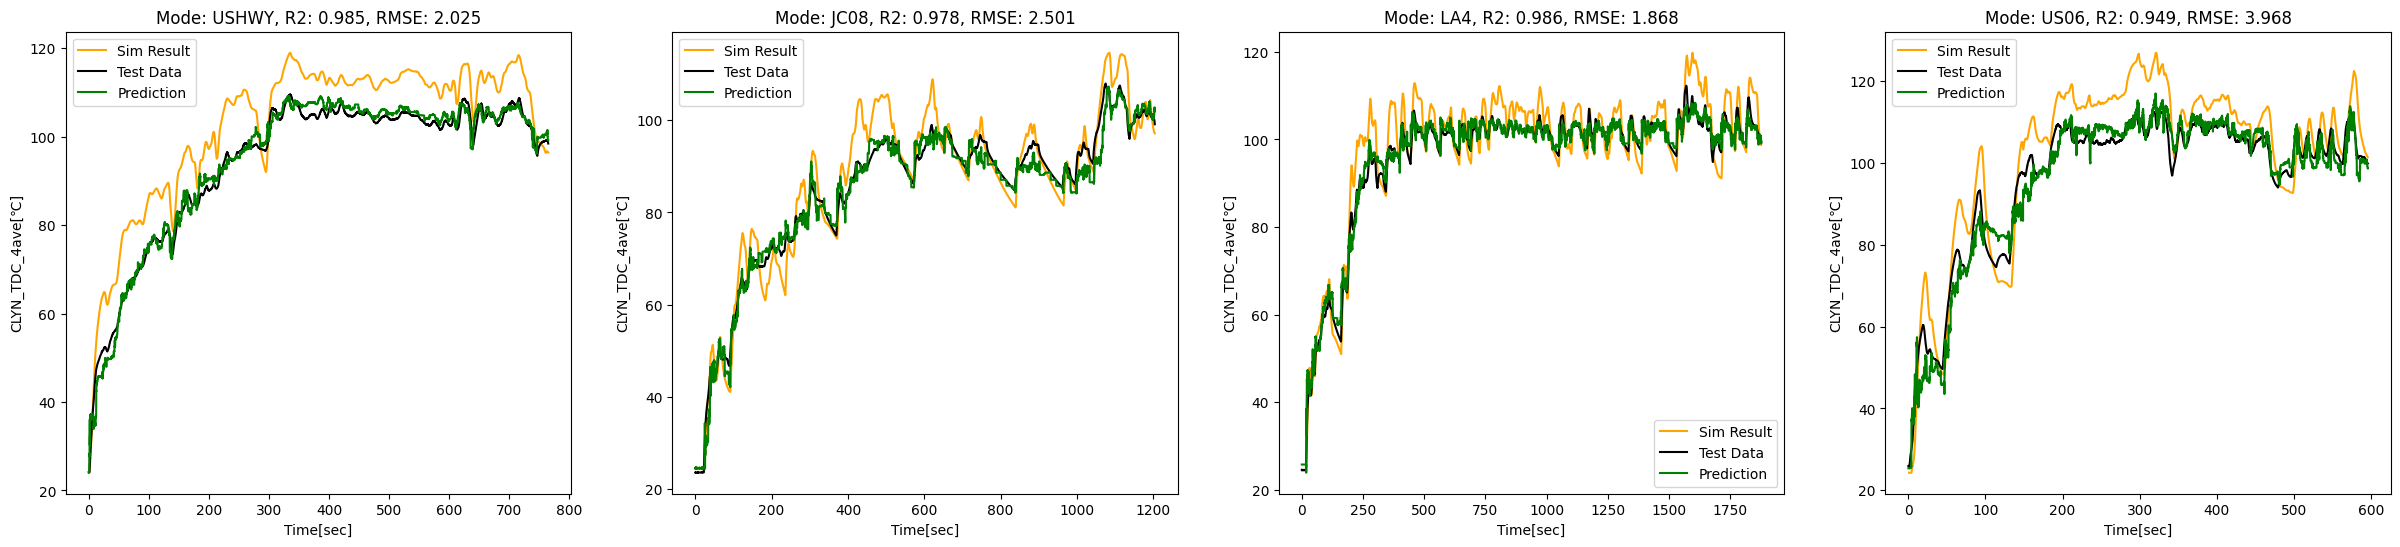

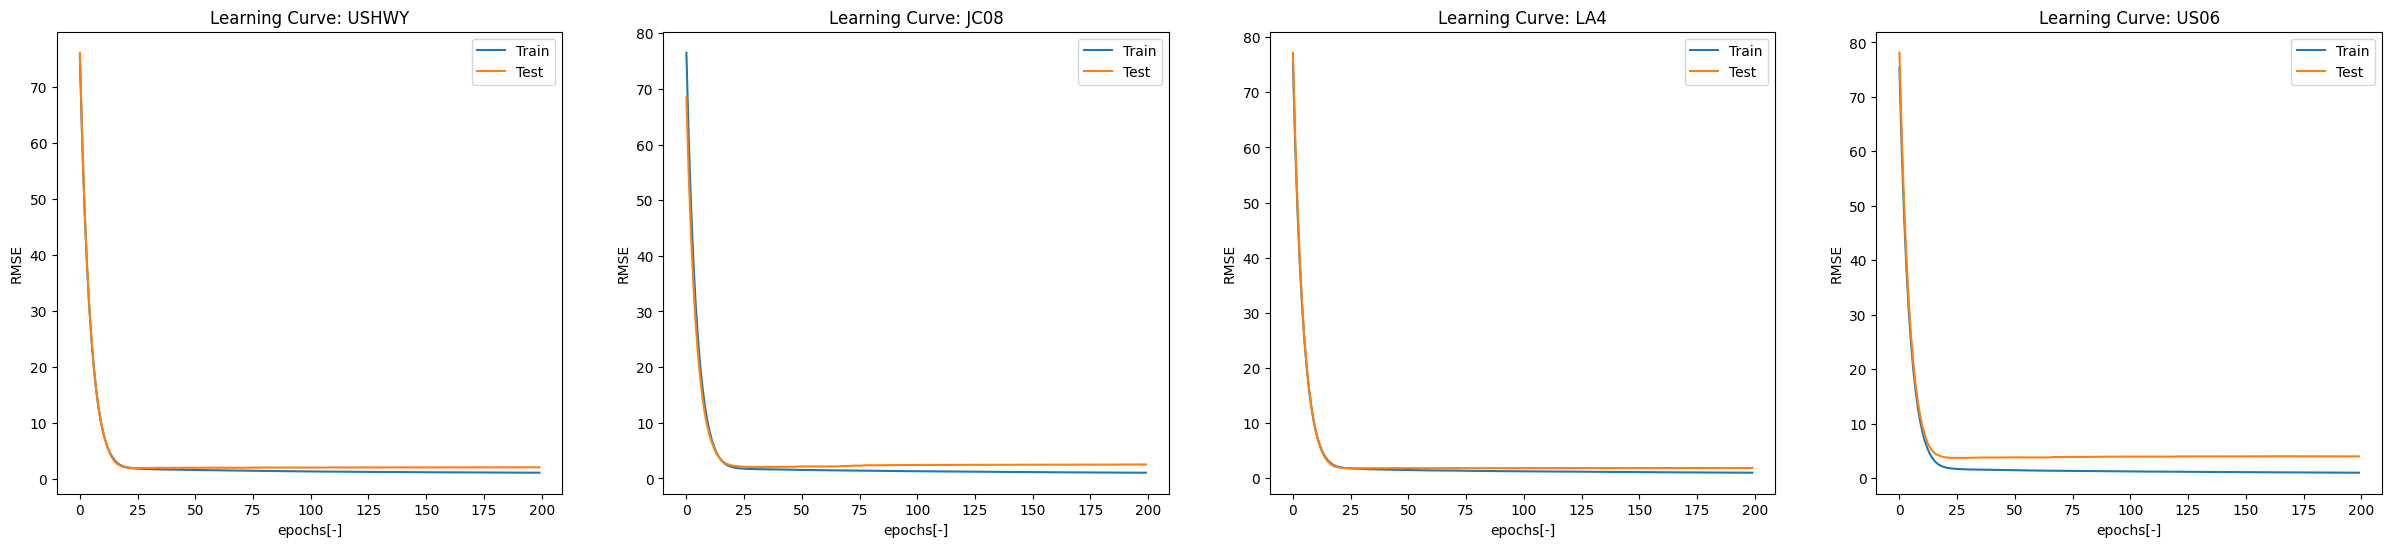

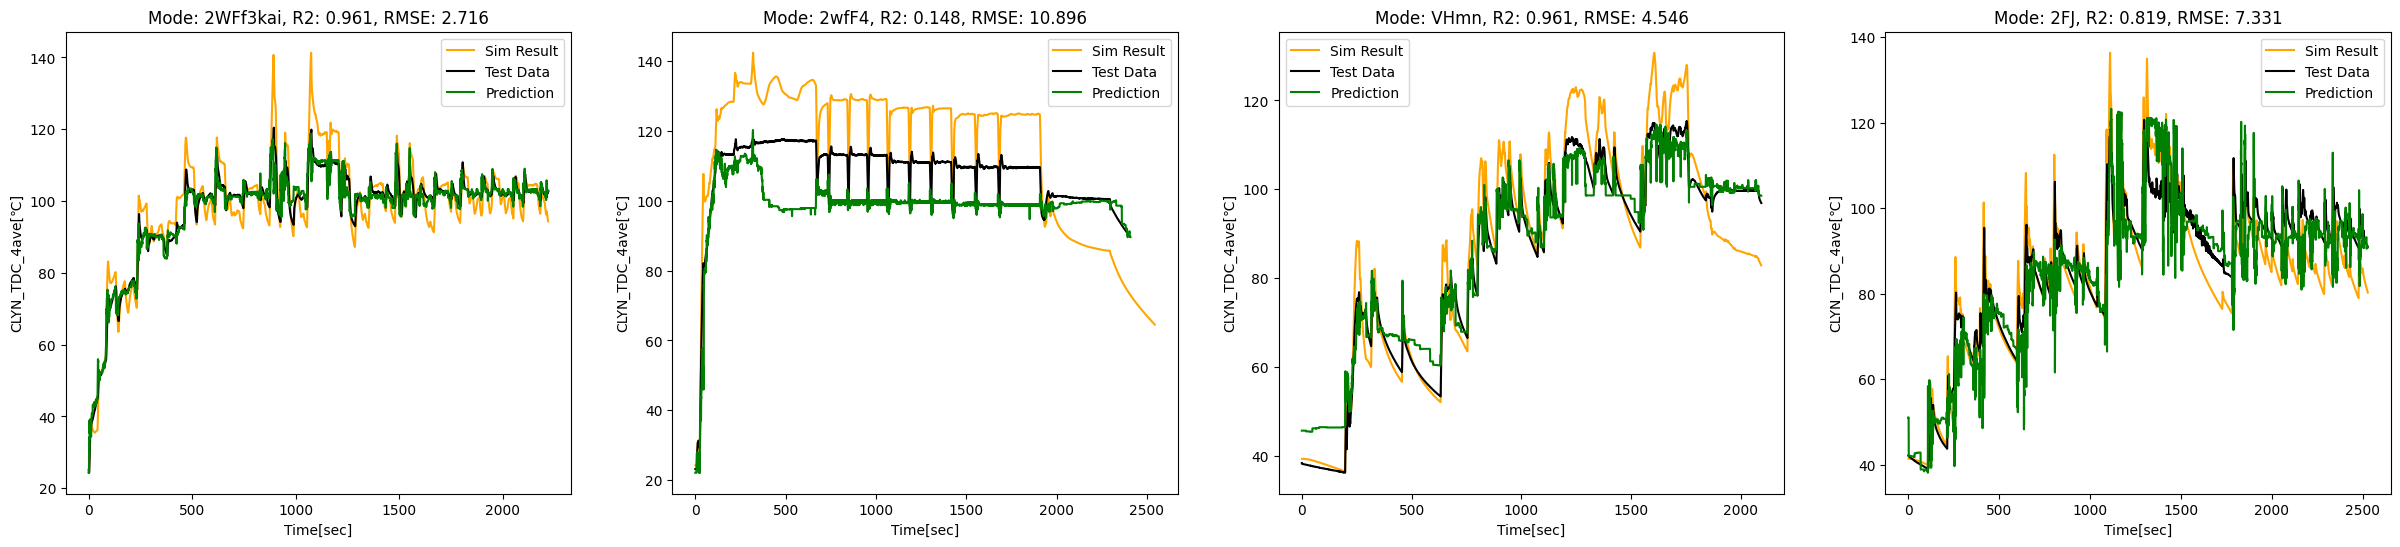

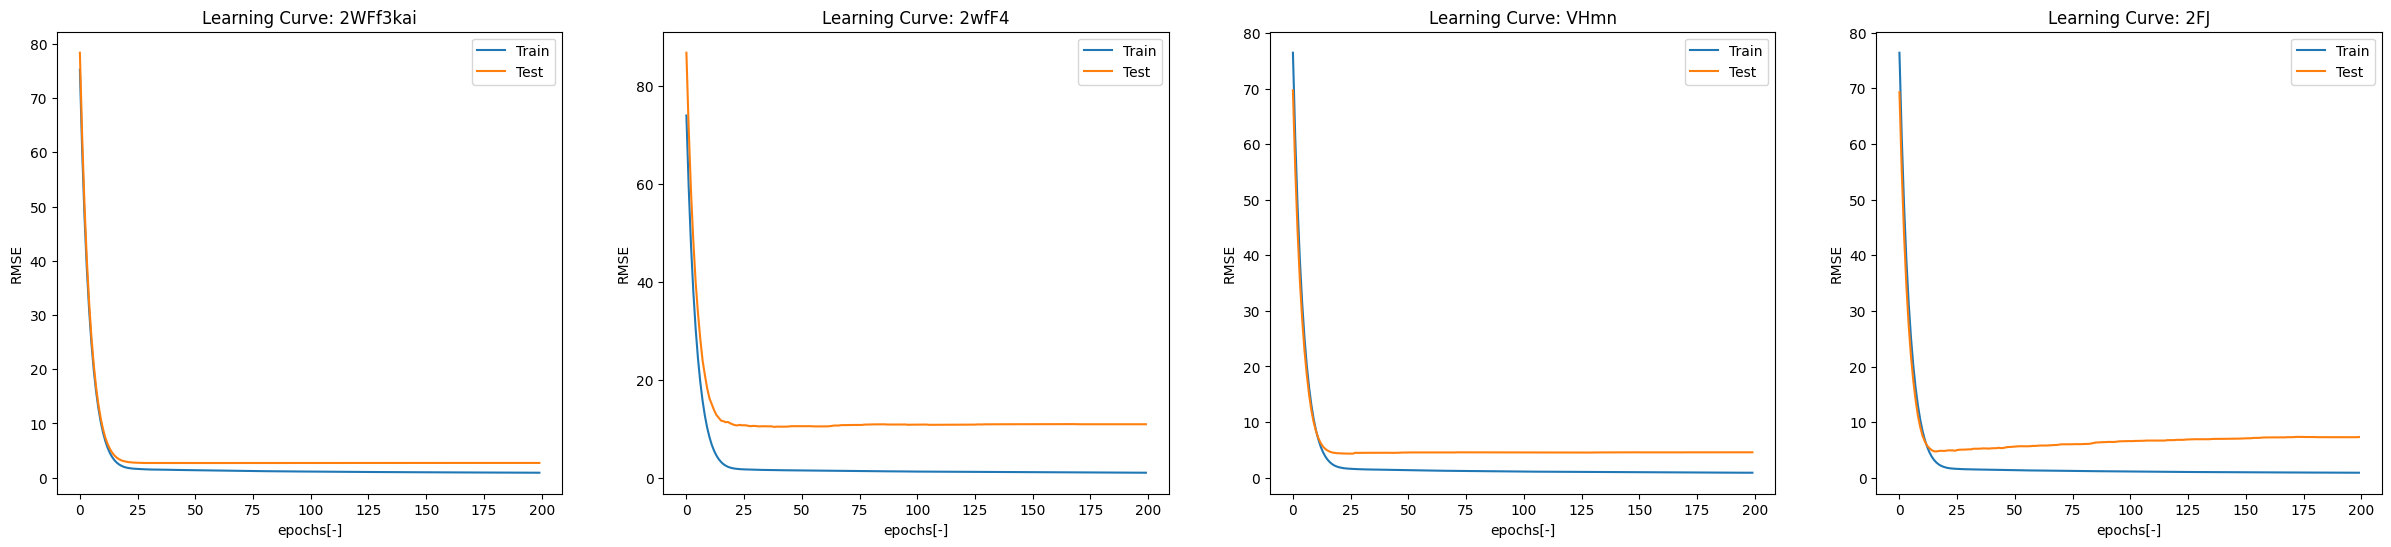

In [8]:
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# 時系列プロット
fig1, axs1 = plt.subplots(1, 4, figsize=(30, 6))
plot_count1 = 0

# 学習曲線プロット
fig2, axs2 = plt.subplots(1, 4, figsize=(30, 6))
plot_count2 = 0

for mode in unique_modes: 
    train_df = df[df['Mode'] != mode]
    test_df = df[df['Mode'] == mode]
    X_train, y_train = prepare_kfold_data(train_df, target_variable, feature_vars)
    X_test, y_test = prepare_kfold_data(test_df, target_variable, feature_vars)

    model = XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse')
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    evals_result = model.evals_result()
    y_pred = model.predict(X_test)

    # Sim data
    filter_dfsim = dfsim[dfsim['Mode'] == mode]
    sim_time_data = filter_dfsim["time"].iloc[:len(y_test)]
    sim_target = filter_dfsim[target_variable].iloc[:len(y_test)]

    # Evaluate
    r2_val = r2_score(y_test, y_pred)
    rmse_val = math.sqrt(mean_squared_error(y_test, y_pred))
    data_count = len(y_test)

    # 時系列プロット
    axs1[plot_count1].plot(sim_time_data, sim_target, label='Sim Result', color='orange')
    axs1[plot_count1].plot(test_df['time'], y_test, label='Test Data', color='black')
    axs1[plot_count1].plot(test_df['time'], y_pred, label='ML Prediction', color='green')
    axs1[plot_count1].set_xlabel('Time[sec]')
    axs1[plot_count1].set_ylabel(target_variable+'[℃]')
    axs1[plot_count1].set_title(f'Mode: {mode}, R2: {r2_val:.3f}, RMSE: {rmse_val:.3f}')
    axs1[plot_count1].legend()

    # 学習曲線プロット
    epochs = len(evals_result['validation_0']['rmse'])
    x_axis = range(0, epochs)
    axs2[plot_count2].plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
    axs2[plot_count2].plot(x_axis, evals_result['validation_1']['rmse'], label='Test')
    axs2[plot_count2].set_xlabel('epochs[-]')
    axs2[plot_count2].set_ylabel('RMSE')
    axs2[plot_count2].legend()
    axs2[plot_count2].set_title(f'Learning Curve: {mode}')

    plot_count1 += 1
    plot_count2 += 1

    # 4プロット毎に表示
    if plot_count1 % 4 == 0:
        plt.show()
        if mode != unique_modes[-1]:
            fig1, axs1 = plt.subplots(1, 4, figsize=(30, 6))
            fig2, axs2 = plt.subplots(1, 4, figsize=(30, 6))
            plot_count1 = 0
            plot_count2 = 0


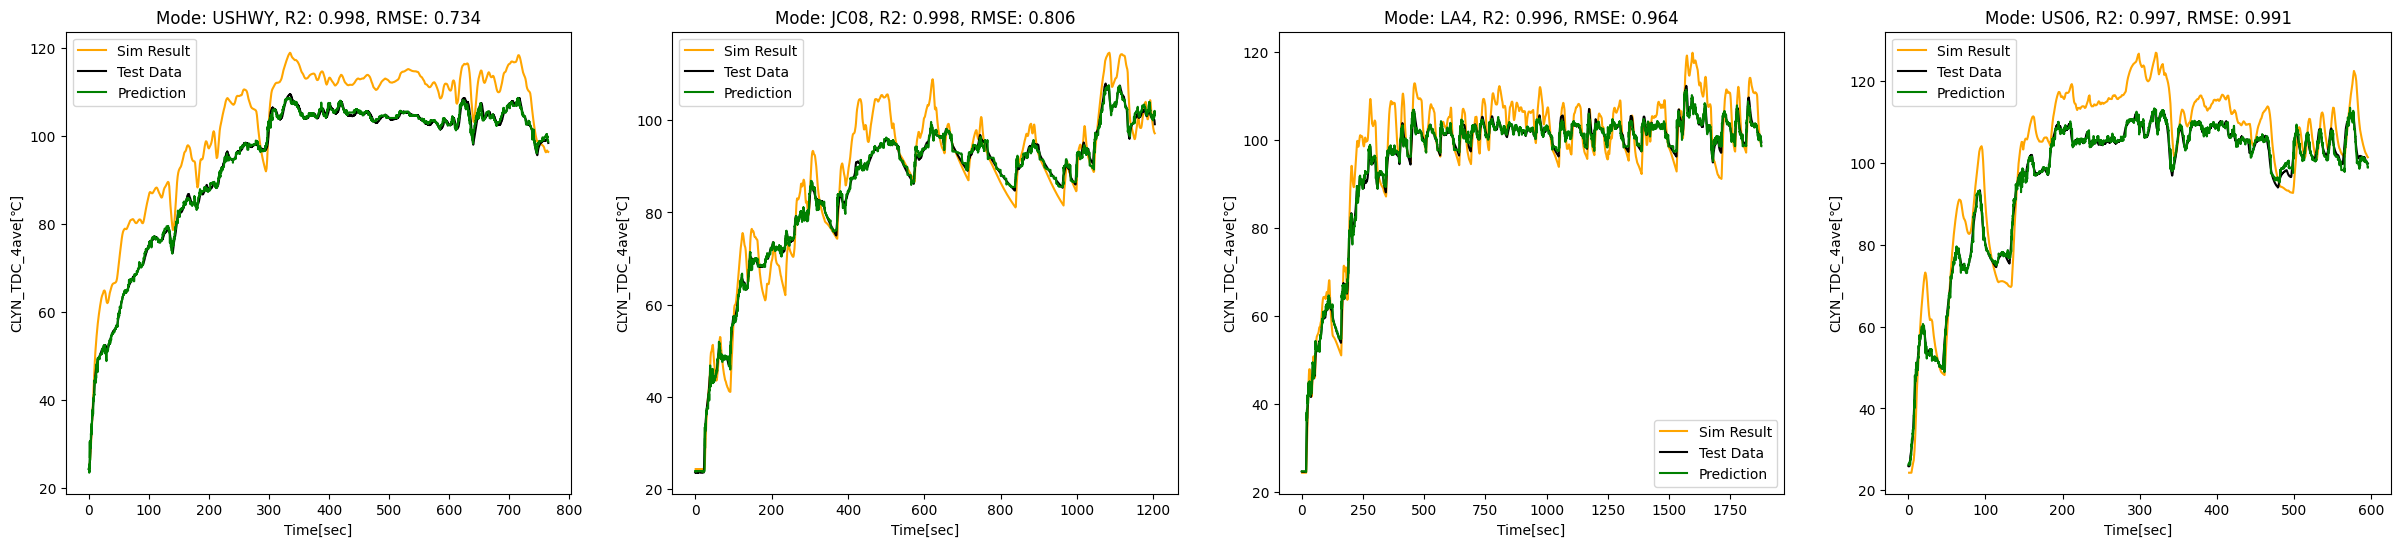

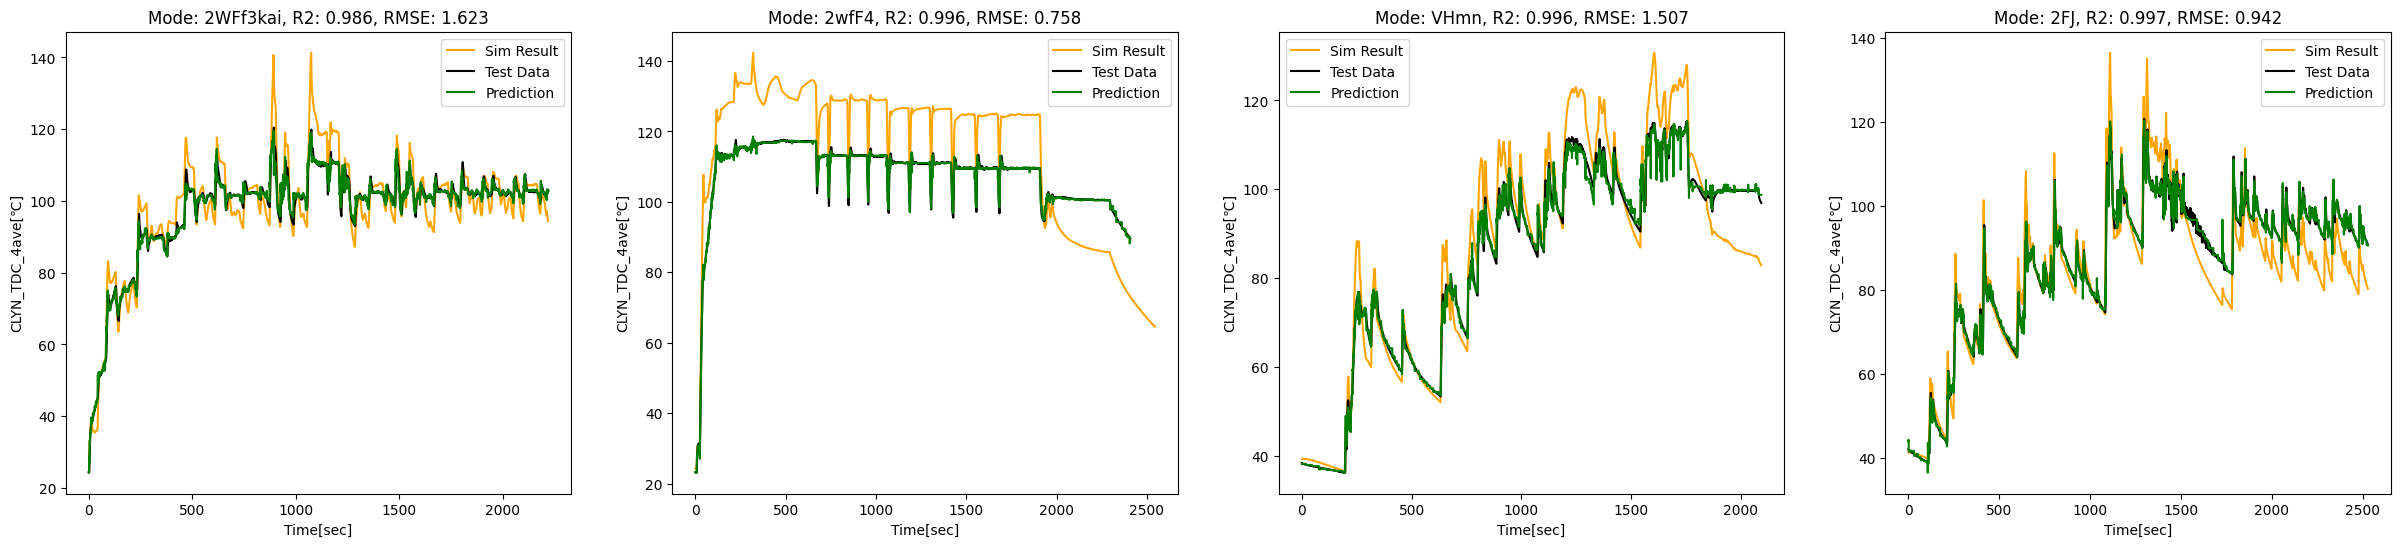

In [10]:
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# プロット初期化
fig1, axs1 = plt.subplots(1, 4, figsize=(30, 6))
plot_count1 = 0

# 層化ランダムサンプリング(stratified random sampling)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Mode'])

X_train, y_train = prepare_kfold_data(train_df, target_variable, feature_vars)
model = XGBRegressor(**best_params, objective='reg:squarederror')
model.fit(X_train, y_train)

for mode in unique_modes: 
    test_df = df[df['Mode'] == mode]
    X_test, y_test = prepare_kfold_data(test_df, target_variable, feature_vars)
    y_pred = model.predict(X_test)

    # Sim data
    filter_dfsim = dfsim[dfsim['Mode'] == mode]
    sim_time_data = filter_dfsim["time"].iloc[:len(y_test)]
    sim_target = filter_dfsim[target_variable].iloc[:len(y_test)]

    # Evaluate
    r2_val = r2_score(y_test, y_pred)
    rmse_val = math.sqrt(mean_squared_error(y_test, y_pred))
    data_count = len(y_test)

    # 時系列プロット
    axs1[plot_count1].plot(sim_time_data, sim_target, label='Sim Result', color='orange')
    axs1[plot_count1].plot(test_df['time'], y_test, label='Test Data', color='black')
    axs1[plot_count1].plot(test_df['time'], y_pred, label='ML Prediction', color='green')
    axs1[plot_count1].set_xlabel('Time[sec]')
    axs1[plot_count1].set_ylabel(target_variable+'[℃]')
    axs1[plot_count1].set_title(f'Mode: {mode}, R2: {r2_val:.3f}, RMSE: {rmse_val:.3f}')
    axs1[plot_count1].legend()

    plot_count1 += 1 

    # 4プロット毎に表示
    if plot_count1 % 4 == 0 and plot_count1 != 0:
        plt.show()
        if mode != unique_modes[-1]:
            fig1, axs1 = plt.subplots(1, 4, figsize=(30, 6))
            plot_count1 = 0 